In [3]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import accuracy

from importlib import reload

In [29]:
colors = ['k', 'gray', 'pink', 'red']
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
chance = [0.0200000226498,
          0.0200000226498,
          0.0200000226498,
          0.0200000226498]

In [30]:
with open(os.path.join(os.environ['HOME'], 'plots/model/data/frac_results.pkl'), 'rb') as f:
    deep_std, deep_all, linear_std, linear_all = pickle.load(f, encoding='latin1')

In [31]:
fracs = sorted(deep_all.keys())

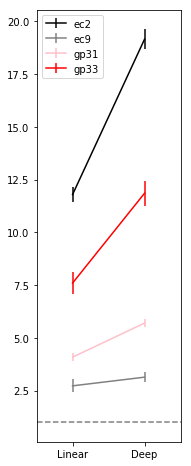

In [33]:
reload(accuracy)
plt.close()
f = plt.figure(figsize=(2, 6))

ax_cv = f.add_axes([0, 0, 1, 1])
accuracy.plot_cv_accuracy(deep_all, linear_all, chance, subjects, fracs, colors, ax_cv)